<a href="https://colab.research.google.com/github/axeelz/2025-m2-idl/blob/main/1-introduction/tp-1-mnist-mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP: Transfer Learning for MNIST Classification

Here you will learn how to use transfer learning to adapt a pre-trained CNN for a new classification task. We will use a small but performant network pre-trained on ImageNet (1000 classes) and adapt it to classify MNIST handwritten digits (10 classes).

**Learning objectives:**
- Understand transfer learning concepts
- Load and prepare the MNIST dataset
- Use a pre-trained model and modify its classification head
- Train only the new layers while freezing pre-trained weights
- Evaluate model performance on a validation set

## System setup

Import the required packages and check PyTorch version.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
import time

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{torch.__version__=}")
print(f"Using {device=}")

torch.__version__='2.9.0+cu126'
Using device='cuda:0'


## Download the MNIST dataset

MNIST is a classic dataset of 28x28 grayscale images of handwritten digits (0-9). It contains:
- 60,000 training images
- 10,000 test images

PyTorch will automatically download the dataset for you.

## Data processing

**Important:** Pre-trained models expect input in a specific format:
- Images must be resized to 224x224 (ImageNet standard)
- Images must have 3 color channels (RGB)
- Images must be normalized with ImageNet statistics

Since MNIST images are:
- 28x28 pixels (too small)
- Grayscale (1 channel instead of 3)

We need to transform them appropriately.

**TODO 1:** Complete the transform pipeline below to:
1. Resize MNIST images to 224x224
2. Convert grayscale to RGB (3 channels)
3. Convert to tensor
4. Normalize with ImageNet statistics

Check the doc of the following transforms:
- [transforms.Resize](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Resize.html)
- [transforms.Grayscale](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Grayscale.html)

In [2]:
# ImageNet normalization statistics
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# TODO 1: Complete this transform pipeline
mnist_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    normalize
])

**TODO 2:** Load the MNIST dataset for training and testing using `datasets.MNIST`.

Hints:
- Set `train=True` for training set, `train=False` for test set
- Set `download=True` to download the dataset
- Use the `mnist_transform` we defined above

MNIST is so popular, the dataset is already available in torchvision: check the doc for [datasets.MNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)

In [3]:
# TODO 2: Load MNIST datasets
data_dir = './mnist'

train_dataset = datasets.MNIST(
    root=data_dir,
    train=True,
    transform=mnist_transform,
    download=True
)

test_dataset = datasets.MNIST(
    root=data_dir,
    train=False,
    transform=mnist_transform,
    download=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.8MB/s]


In [4]:
# Check dataset sizes
dset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
print(f"Training set size: {dset_sizes['train']}")
print(f"Test set size: {dset_sizes['test']}")

Training set size: 60000
Test set size: 10000


Let's examine the MNIST class labels:

In [5]:
mnist_classes = train_dataset.classes
print(f"MNIST classes: {mnist_classes}")
print(f"Number of classes: {len(mnist_classes)}")

MNIST classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of classes: 10


**TODO 3:** Create DataLoaders for training and testing.

Hints:
- Use batch_size=64 for training
- Use batch_size=100 for testing
- Shuffle training data but not test data
- Set num_workers=2 (lower than dogs/cats example for CPU training)

Check the doc for [torch.utils.data.DataLoader](https://docs.pytorch.org/docs/stable/data.html)

In [6]:
# TODO 3: Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Let's visualize some examples from the training set:

In [7]:
# Get a batch of training data
inputs, labels = next(iter(train_loader))

print(f"Batch shape: {inputs.shape}")
print(f"Labels: {labels[:8]}")

Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([4, 8, 5, 1, 9, 6, 8, 3])


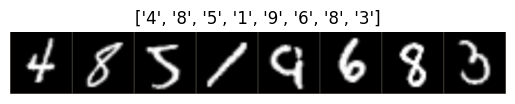

In [9]:
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Make a grid from batch
n_images = 8
out = torchvision.utils.make_grid(inputs[0:n_images])
imshow(out, title=[str(x.item()) for x in labels[0:n_images]])

## Load a pre-trained model: MobileNetV3

We will use [**MobileNetV3-small**](https://huggingface.co/qualcomm/MobileNet-v3-Small), a small and efficient CNN designed for mobile devices. Despite its small size (~2.5M parameters), it achieves relatively good performance on ImageNet for its size.

Let's load the pre-trained model:

In [10]:
# Load pre-trained MobileNetV2
model = models.mobilenet_v3_small(weights='DEFAULT')
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 91.4MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Let's examine the structure of MobileNetV2:
- `features`: Convolutional layers for feature extraction
- `classifier`: Final classification layer(s)

The classifier outputs 1000 classes (ImageNet). We need to modify it for 10 classes (MNIST digits).

In [11]:
print("\nClassifier structure:")
print(model.classifier)


Classifier structure:
Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)


## Modify the classification head

**Transfer learning strategy:**
1. Freeze all pre-trained weights (no gradient computation)
2. Replace the final layer to output 10 classes instead of 1000
3. Train only the new layer

**TODO 4:** Complete the code below to:
1. Freeze all parameters in the model
2. Replace the final linear layer with a new one for 10 classes

Hints:
- The classifier is a Sequential with Dropout and Linear layers
- The Linear layer is at index 3: `model.classifier[3]`
- The input features to this layer is 1024 (check the print above)

In [12]:
# TODO 4: Freeze all parameters and replace final layer

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer: Linear(1024, 1000) -> Linear(1024, 10)
model.classifier[3] = nn.Linear(1024, 10)

print("\nModified classifier:")
print(model.classifier)


Modified classifier:
Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=10, bias=True)
)


In [13]:
# Move model to device (GPU/MPS/CPU)
model = model.to(device)

# Verify: count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


Total parameters: 1,528,106
Trainable parameters: 10,250
Frozen parameters: 1,517,856


**Question:** How many parameters do we need to train?

**Answer:** The final linear layer has 1024 input features and 10 output classes, so:
- Weights: 1024 × 10 = 10,240
- Bias: 10
- **Total: 10,250 parameters**

This is very small compared to the full model (~2.5M parameters)!

## Training the new layer

### Creating loss function and optimizer

**TODO 5:** Create the loss function and optimizer.

Hints:
- Use CrossEntropyLoss for multi-class classification
- Use SGD optimizer with learning_rate=0.01 and momentum=0.9
- Only pass the parameters of the new layer to the optimizer: `model.classifier[3].parameters()`

Check the doc for:
- [nn.CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.loss.CrossEntropyLoss.html)
- [torch.optim.SGD](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [14]:
# TODO 5: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier[3].parameters(),lr=0.01, momentum=0.9)

### Training loop

Now let's train the model. The training function performs:
1. Forward pass: compute predictions
2. Loss computation: compare predictions with true labels
3. Backward pass: compute gradients
4. Optimizer step: update weights

In [15]:
from tqdm import tqdm

def train_model(model, dataloader, size, epochs=1, optimizer=None):
    """Train the model for given number of epochs."""
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0

        for inputs, classes in tqdm(dataloader):
            inputs, classes = inputs.to(device), classes.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, classes)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            _, preds = torch.max(outputs.data, 1)
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)

        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

**TODO 6:** Train the model for 3 epochs.

Note: This should run on CPU in a reasonable time, but still need a few minutes per epoch.

In [16]:
%%time
# TODO 6: Train the model
train_model(model, train_loader, size=dset_sizes['train'], epochs=3, optimizer=optimizer)

100%|██████████| 938/938 [01:42<00:00,  9.17it/s]


Epoch 1/3 - Loss: 0.0045 Acc: 0.9258


100%|██████████| 938/938 [01:41<00:00,  9.20it/s]


Epoch 2/3 - Loss: 0.0025 Acc: 0.9540


100%|██████████| 938/938 [01:59<00:00,  7.84it/s]

Epoch 3/3 - Loss: 0.0022 Acc: 0.9590
CPU times: user 1min 19s, sys: 31.5 s, total: 1min 50s
Wall time: 5min 23s


## Evaluation

Now let's test our model on the test set.

In [17]:
def test_model(model, dataloader, size):
    """Evaluate the model on test data."""
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size, 10))

    i = 0
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, classes)

            _, preds = torch.max(outputs.data, 1)

            # Statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)

            predictions[i:i+len(classes)] = preds.to('cpu').numpy()
            all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
            all_proba[i:i+len(classes), :] = nn.functional.softmax(outputs, dim=1).to('cpu').numpy()
            i += len(classes)

    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return predictions, all_proba, all_classes

In [18]:
%%time
predictions, all_proba, all_classes = test_model(model, test_loader, size=dset_sizes['test'])

Test Loss: 0.0011 Acc: 0.9667
CPU times: user 3.93 s, sys: 1.66 s, total: 5.59 s
Wall time: 17.7 s


## Model analysis

Let's analyze the model's predictions to understand its behavior.

### 1. Correct predictions

First, let's look at some correct predictions:

In [21]:
# Overall accuracy
correct = np.where(predictions==all_classes)[0]
accuracy = len(correct) / dset_sizes['test']
print(f"Test accuracy: {accuracy:.4f} ({len(correct)}/{dset_sizes['test']} correct)")

Test accuracy: 0.9667 (9667/10000 correct)


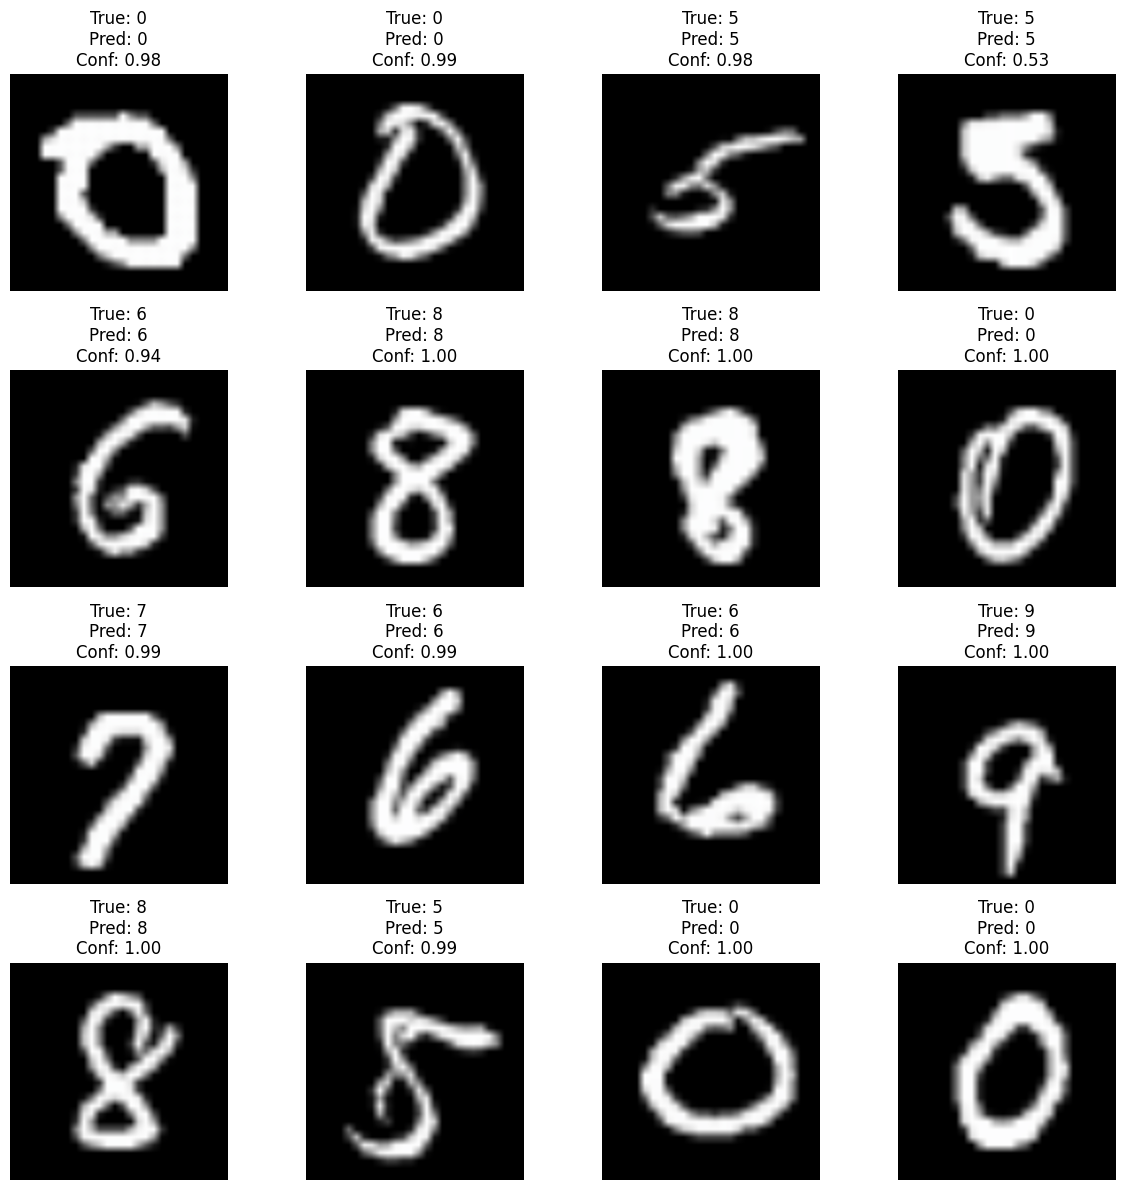

In [22]:
# Visualize some correct predictions
from numpy.random import permutation

n_view = 16
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for idx, x in enumerate(permutation(correct)[:n_view]):
    img, label = test_dataset[x]
    img_np = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = np.clip(std * img_np + mean, 0, 1)

    axes[idx].imshow(img_np)
    axes[idx].set_title(f'True: {int(all_classes[x])}\nPred: {int(predictions[x])}\nConf: {all_proba[x, int(predictions[x])]:.2f}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 2. Incorrect predictions

Let's examine where the model fails:

Number of incorrect predictions: 333


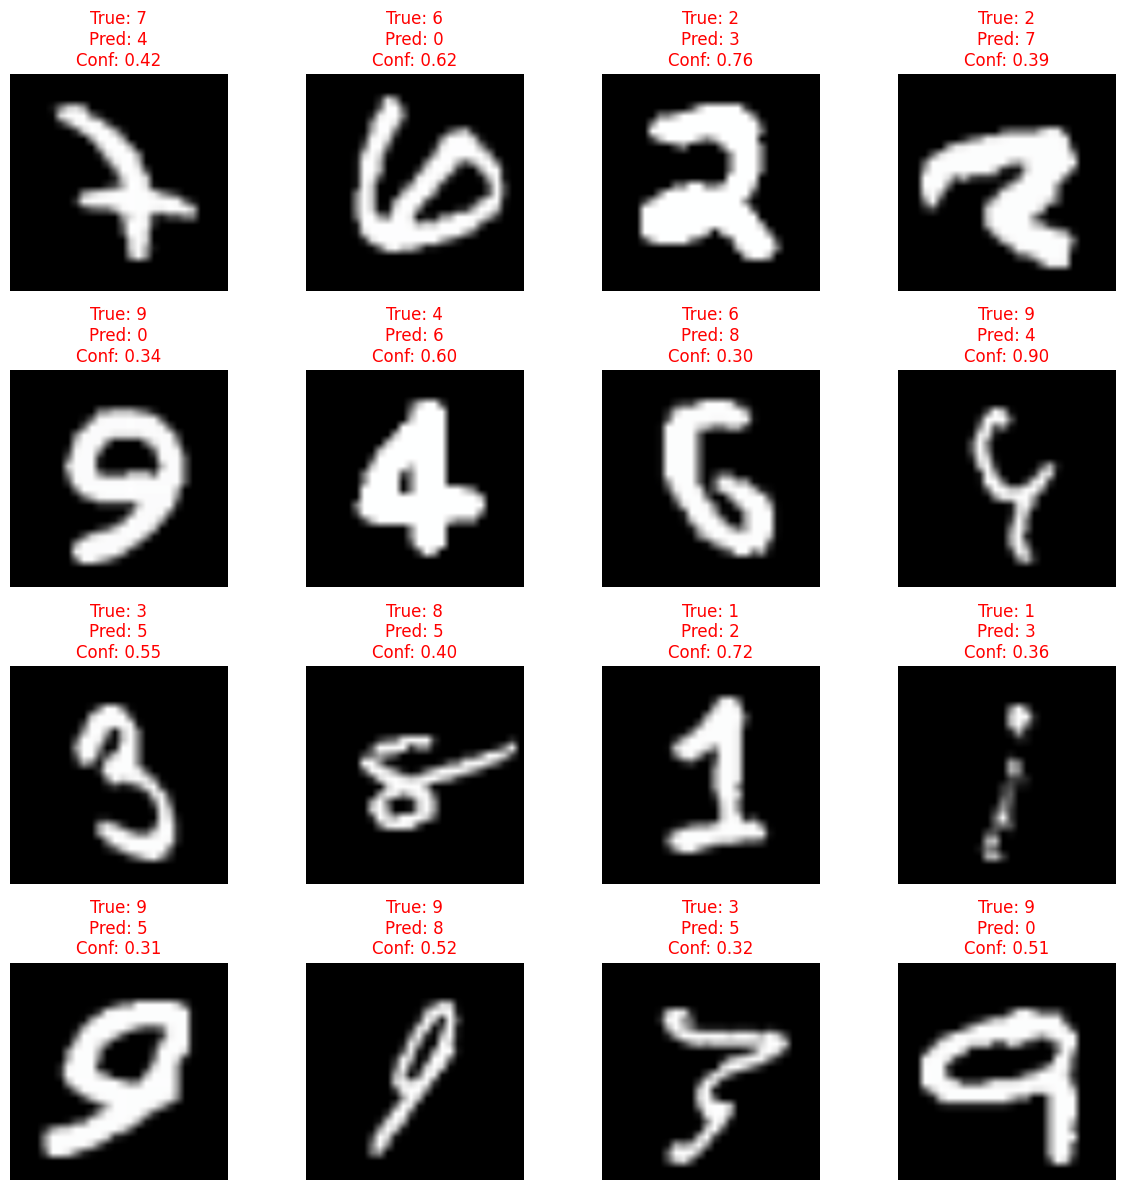

In [28]:
# Visualize incorrect predictions
incorrect = np.where(predictions!=all_classes)[0]
print(f"Number of incorrect predictions: {len(incorrect)}")

if len(incorrect) > 0:
    n_view = min(16, len(incorrect))
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for idx, x in enumerate(permutation(incorrect)[:n_view]):
        img, label = test_dataset[x]
        img_np = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = np.clip(std * img_np + mean, 0, 1)

        axes[idx].imshow(img_np)
        axes[idx].set_title(f'True: {int(all_classes[x])}\nPred: {int(predictions[x])}\nConf: {all_proba[x, int(predictions[x])]:.2f}',
                           color='red')
        axes[idx].axis('off')

    # Hide unused subplots
    for idx in range(n_view, 16):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

### 3. Most confident predictions

Let's look at predictions where the model is most confident:

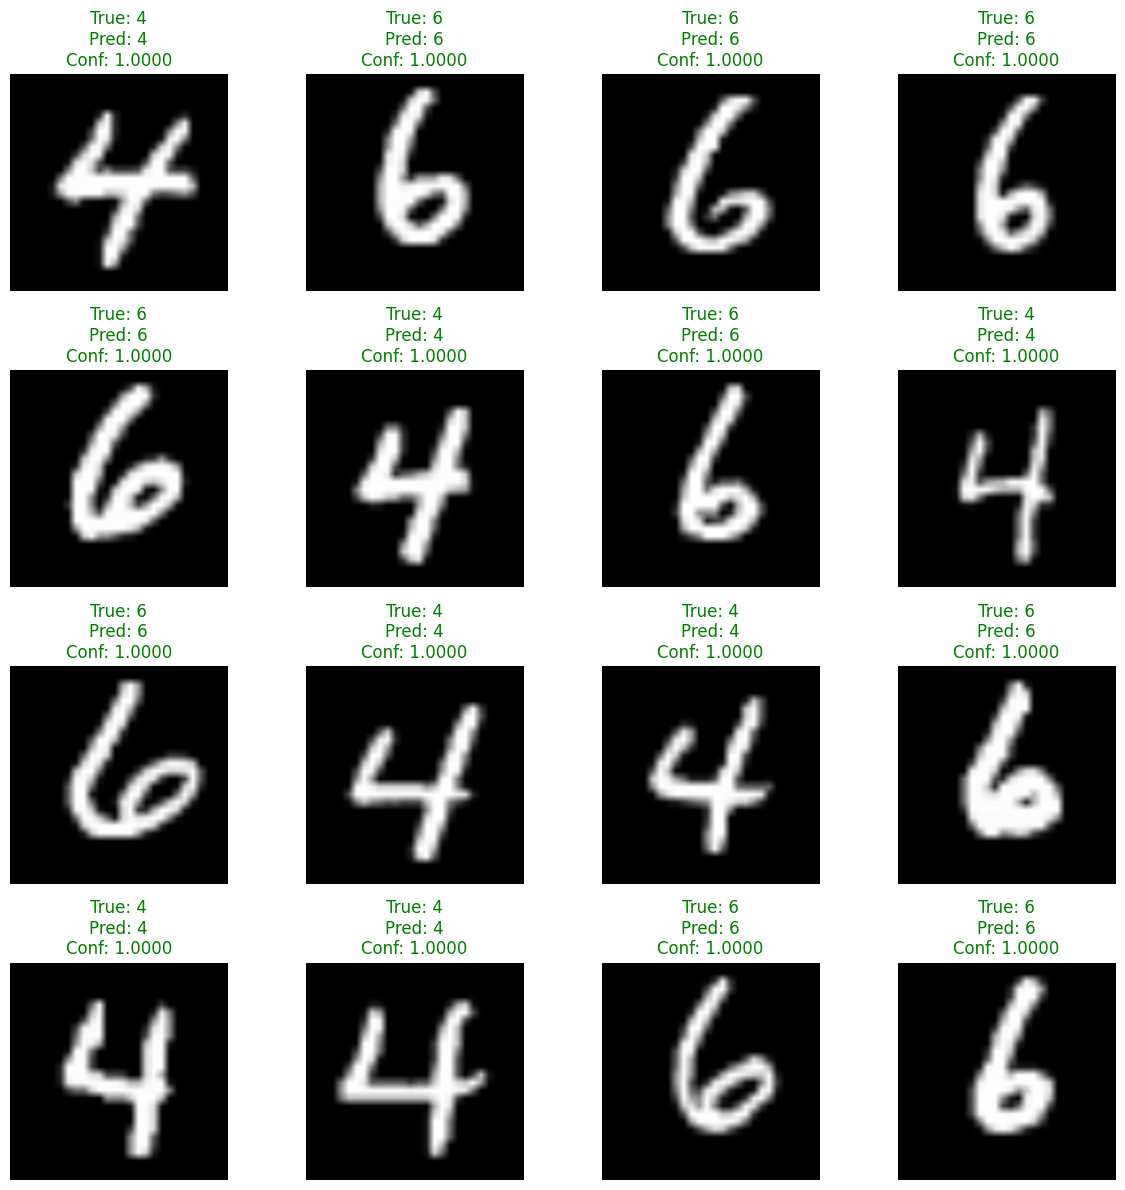

In [27]:
# Most confident predictions (highest probability)
confidences = np.max(all_proba, axis=1)
most_confident_idx = np.argsort(-confidences)[:n_view]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for idx, x in enumerate(most_confident_idx):
    img, label = test_dataset[x]
    img_np = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = np.clip(std * img_np + mean, 0, 1)

    axes[idx].imshow(img_np)
    is_correct = predictions[x] == all_classes[x]
    color = 'green' if is_correct else 'red'
    axes[idx].set_title(f'True: {int(all_classes[x])}\nPred: {int(predictions[x])}\nConf: {confidences[x]:.4f}',
                       color=color)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4. Most uncertain predictions

Finally, let's examine cases where the model is uncertain:

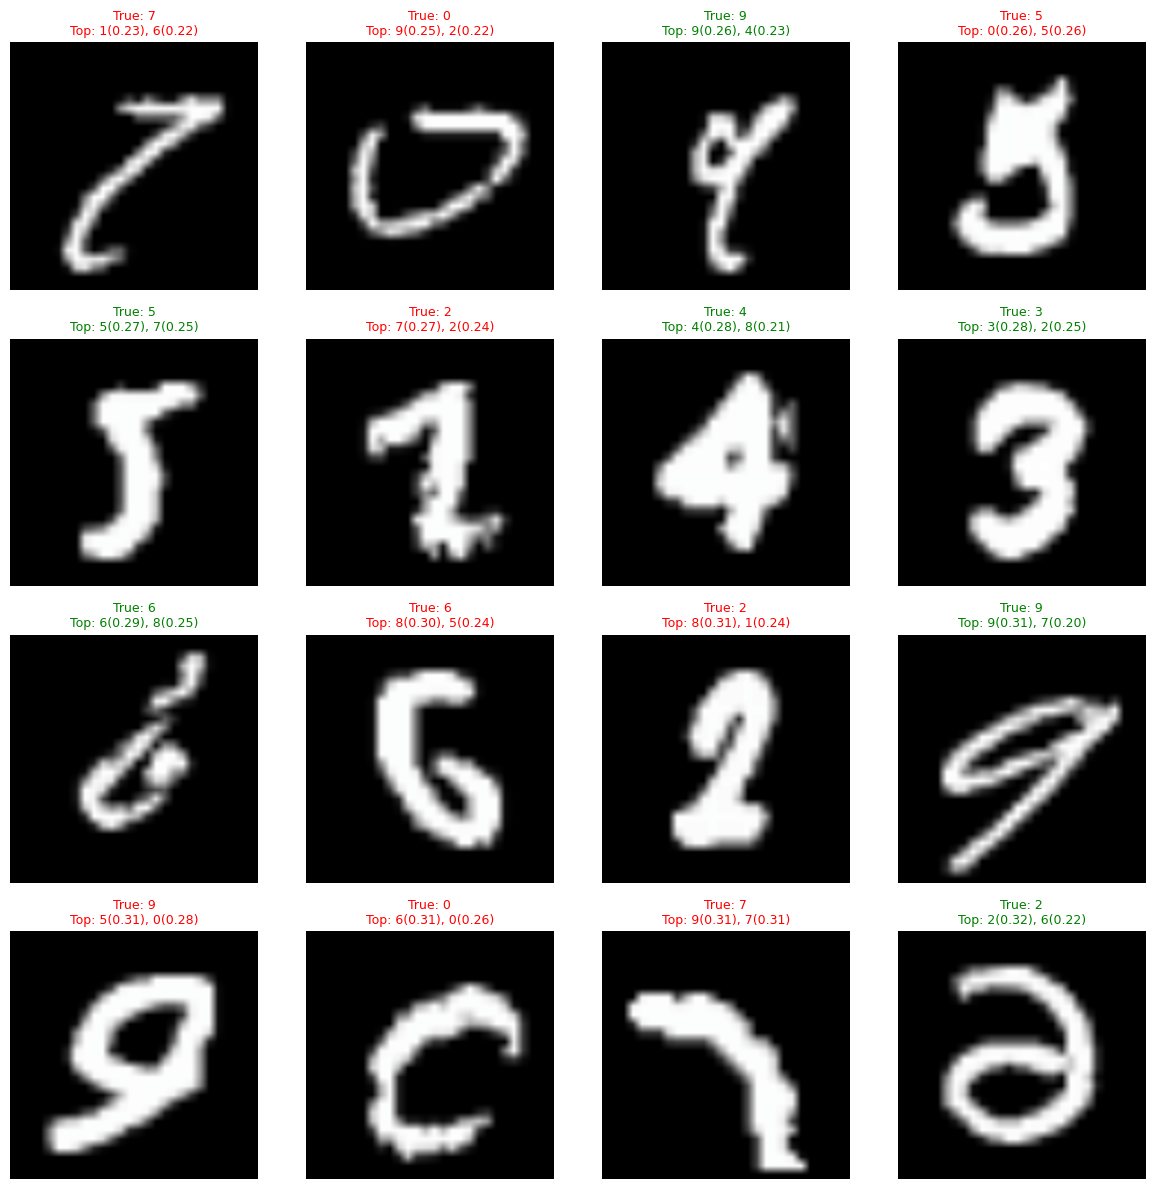

In [30]:
# Most uncertain predictions (probability closest to uniform)
uncertainty = 1 - np.max(all_proba, axis=1)
most_uncertain_idx = np.argsort(-uncertainty)[:n_view]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for idx, x in enumerate(most_uncertain_idx):
    img, label = test_dataset[x]
    img_np = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = np.clip(std * img_np + mean, 0, 1)

    axes[idx].imshow(img_np)
    is_correct = predictions[x] == all_classes[x]
    color = 'green' if is_correct else 'red'

    # Show top 2 predictions
    top2_idx = np.argsort(-all_proba[x])[:2]
    top2_prob = all_proba[x][top2_idx]

    axes[idx].set_title(f'True: {int(all_classes[x])}\nTop: {top2_idx[0]}({top2_prob[0]:.2f}), {top2_idx[1]}({top2_prob[1]:.2f})',
                       color=color, fontsize=9)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 5. Confusion matrix

A confusion matrix helps us understand which digits are confused with each other:

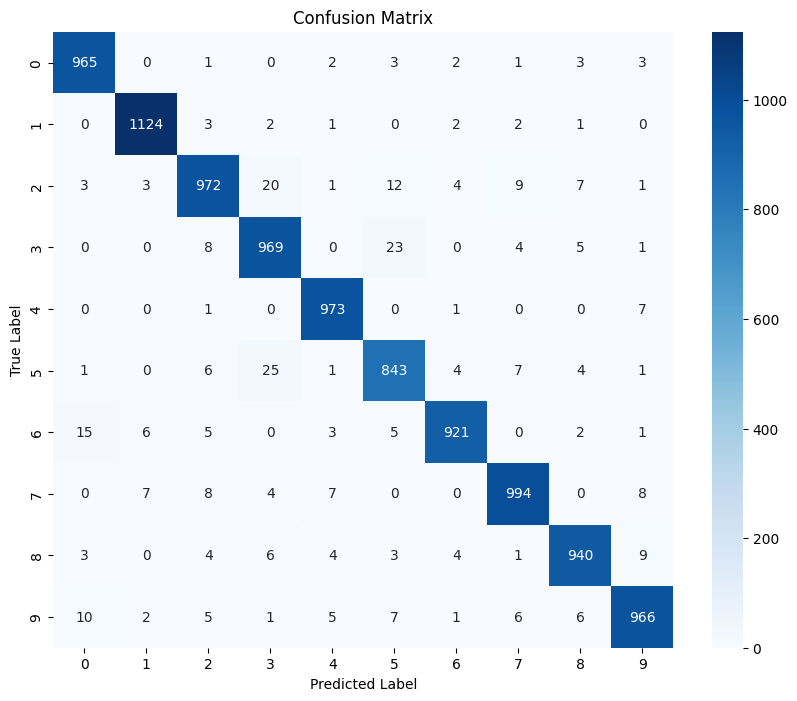

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_classes, predictions)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### 6. Per-class accuracy

Let's see how well the model performs on each digit:

In [33]:
# Per-class accuracy
for digit in range(10):
    digit_mask = all_classes == digit
    digit_correct = np.sum((predictions == all_classes) & digit_mask)
    digit_total = np.sum(digit_mask)
    digit_acc = digit_correct / digit_total
    print(f"Digit {digit}: {digit_acc:.4f} ({digit_correct}/{digit_total})")

Digit 0: 0.9847 (965/980)
Digit 1: 0.9903 (1124/1135)
Digit 2: 0.9419 (972/1032)
Digit 3: 0.9594 (969/1010)
Digit 4: 0.9908 (973/982)
Digit 5: 0.9451 (843/892)
Digit 6: 0.9614 (921/958)
Digit 7: 0.9669 (994/1028)
Digit 8: 0.9651 (940/974)
Digit 9: 0.9574 (966/1009)


## Conclusion

In this practical, you have:

1. **Learned transfer learning**: You used a model pre-trained on ImageNet (natural images) and adapted it to MNIST (handwritten digits)
2. **Understood domain adaptation**: MNIST images are very different from ImageNet (grayscale, simple shapes vs. color, complex objects), yet transfer learning still works!
3. **Trained efficiently**: By freezing pre-trained weights and training only the final layer, you trained the model in just a few minutes
4. **Achieved good performance**: With only ~12,800 trainable parameters, the model likely achieved >90% accuracy

### Extension ideas:

Try modifying the code to:
1. **Fine-tune more layers**: Unfreeze some earlier layers and train with a smaller learning rate
2. **Add data augmentation**: Apply random rotations, translations to improve robustness
3. **Compare architectures**: Try other small models used for classification
4. **Use a different dataset**: Try Fashion-MNIST or CIFAR-10